# Import Libraries

In [ ]:
import torch
import numpy as np
import csv
import pandas as pd
import ast
from transformers import AutoTokenizer, AutoModel
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import umap
import plotly.express as px
from collections import defaultdict

# Download And Load the Model

We used the FinBERT encoder because it is fine-tuned for finance-related tasks. So we dxpect to generate better embeddings for us

In [ ]:
# Load FinBERT tokenizer and model
model_name = "ProsusAI/finbert"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)


# Test the Model

In [ ]:
text = "Apple shares rallied after the company posted record earnings."

inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)

with torch.no_grad():
    outputs = model(**inputs)

cls_embedding = outputs.last_hidden_state[:, 0, :]  # shape: [batch_size, hidden_size]

cls_embedding = torch.nn.functional.normalize(cls_embedding, p=2, dim=1)

embedding_vector = cls_embedding[0].cpu().squeeze().numpy()

print("Embedding shape:", embedding_vector.shape)
print("Embedding vector (truncated):", embedding_vector[:10])

Embedding shape: (768,)
Embedding vector (truncated): [ 0.05051492 -0.04822997  0.03684108  0.0064095  -0.01757147  0.00882037
  0.0132683   0.00099412  0.0366137   0.02412546]


# Run the model on data

In [ ]:
#Run on GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

## Generate Embeddings

We should generate each comment's embedding and save it in the dataset

In [ ]:
# Mean pooling function (alternative to CLS)
def get_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    cls_embedding = outputs.last_hidden_state[:, 0, :]  # [CLS] token
    cls_embedding = torch.nn.functional.normalize(cls_embedding, p=2, dim=1)  # Normalize
    return cls_embedding[0].cpu().numpy()

df = pd.read_csv("input.csv")

# Generate embeddings
embeddings = []
for text in df["text"]:
    try:
        emb = get_embedding(text)
        embeddings.append(emb.tolist())
        a = len(embeddings)
        print(f"Total Embeddings:{a}")
    except Exception as e:
        print(f"Error processing row: {e}")
        embeddings.append([None])  # Handle errors gracefully


# Add to DataFrame
df["embedding"] = embeddings

# Save to new CSV
df.to_csv("comments_with_embeddings.csv", index=False)

print("Done! Embeddings saved to 'comments_with_embeddings.csv'")

Total Embeddings:1
Total Embeddings:2
Total Embeddings:3
Total Embeddings:4
Total Embeddings:5
Total Embeddings:6
Total Embeddings:7
Total Embeddings:8
Total Embeddings:9
Total Embeddings:10
Total Embeddings:11
Total Embeddings:12
Total Embeddings:13
Total Embeddings:14
Total Embeddings:15
Total Embeddings:16
Total Embeddings:17
Total Embeddings:18
Total Embeddings:19
Total Embeddings:20
Total Embeddings:21
Total Embeddings:22
Total Embeddings:23
Total Embeddings:24
Total Embeddings:25
Total Embeddings:26
Total Embeddings:27
Total Embeddings:28
Total Embeddings:29
Total Embeddings:30
Total Embeddings:31
Total Embeddings:32
Total Embeddings:33
Total Embeddings:34
Total Embeddings:35
Total Embeddings:36
Total Embeddings:37
Total Embeddings:38
Total Embeddings:39
Total Embeddings:40
Total Embeddings:41
Total Embeddings:42
Total Embeddings:43
Total Embeddings:44
Total Embeddings:45
Total Embeddings:46
Total Embeddings:47
Total Embeddings:48
Total Embeddings:49
Total Embeddings:50
Total Emb

### Show one random embedding

In [ ]:
print(embeddings[232])
print(len(embeddings[232]))
print(type(embeddings))

[0.02398105338215828, 0.03022310696542263, -0.022663777694106102, -0.0037626130506396294, 0.004690465051680803, -0.012796415947377682, 0.026563333347439766, 0.05052303150296211, -0.003835051553323865, 0.040924072265625, -0.0004576802020892501, -0.008441658690571785, 0.007145144045352936, 0.022704482078552246, -0.03059481829404831, 0.005324935540556908, 0.004956272896379232, 0.03172345459461212, 0.026597702875733376, 0.010782415978610516, 0.04939662665128708, 0.0069745369255542755, -0.032842595130205154, 0.008585919626057148, 0.03969573602080345, 0.03183465451002121, 0.018456773832440376, -0.01845003105700016, 0.02037452906370163, 0.03982449322938919, 0.025504475459456444, 0.052105341106653214, 0.016908472403883934, -0.011462816968560219, 0.051086992025375366, -0.028158826753497124, 0.04312073066830635, -0.028308184817433357, -0.03731052204966545, 0.018053041771054268, -0.10492446273565292, -0.03395423665642738, 0.05656242370605469, -0.02473006583750248, 0.011954374611377716, -0.0945627

## Embeddings Distribution

Let's Take a look at embeddings distribution. We used 3 different Dimensionality Reduction techniques to show the distributions in 2D and 3D.

C:\Users\Alime\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Alime\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


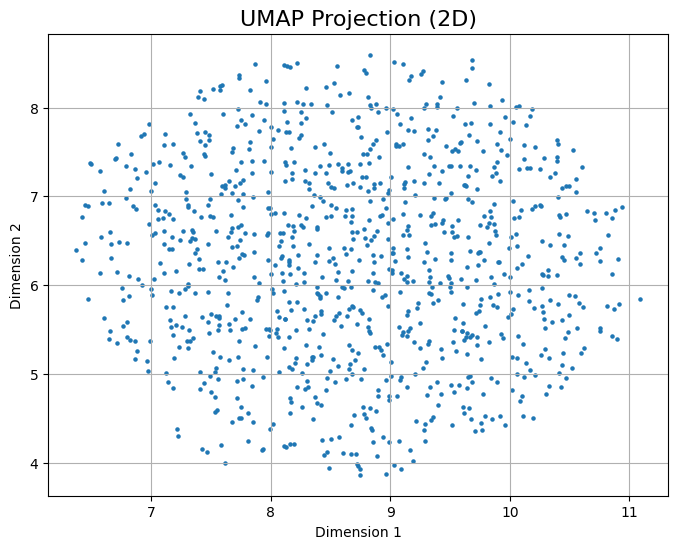

C:\Users\Alime\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Alime\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


<Figure size 800x600 with 0 Axes>

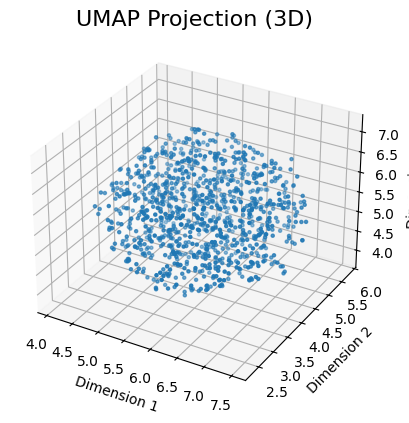

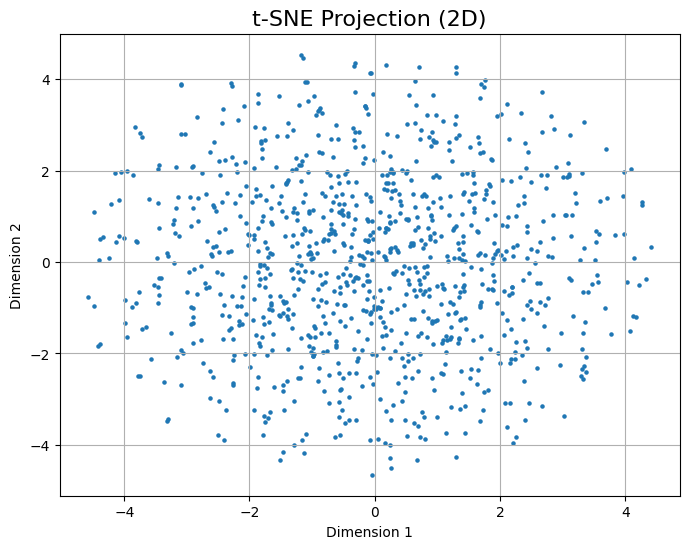

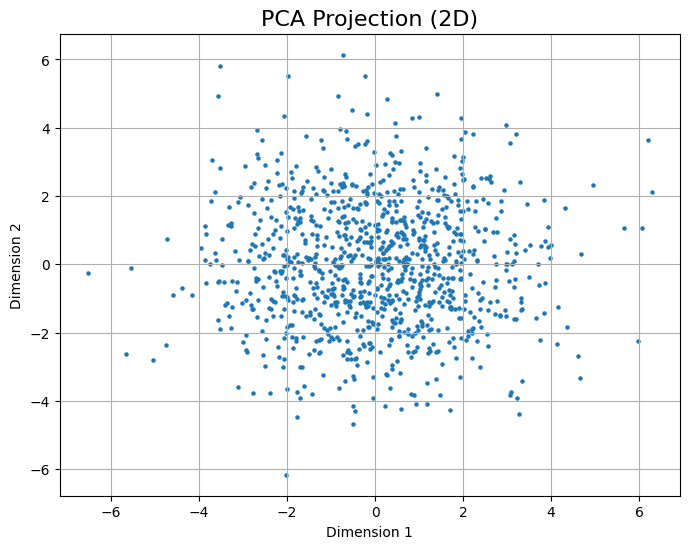

In [ ]:
def visualize_embeddings_reduced(embeddings, method='UMAP', n_components=2):

    embeddings_array = np.array(embeddings)

    if method == 'UMAP':
        reducer = umap.UMAP(n_components=n_components, random_state=42)
        reduced_embeddings = reducer.fit_transform(embeddings_array)
        title = f'UMAP Projection ({n_components}D)'
    elif method == 't-SNE':
        from sklearn.manifold import TSNE
        reducer = TSNE(n_components=n_components, random_state=42)
        reduced_embeddings = reducer.fit_transform(embeddings_array)
        title = f't-SNE Projection ({n_components}D)'
    elif method == 'PCA':
        from sklearn.decomposition import PCA
        reducer = PCA(n_components=n_components)
        reduced_embeddings = reducer.fit_transform(embeddings_array)
        title = f'PCA Projection ({n_components}D)'
    else:
        raise ValueError("Invalid method. Choose 'UMAP', 't-SNE', or 'PCA'.")

    # Create the plot
    plt.figure(figsize=(8, 6))
    if n_components == 2:
        plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], s=5)  # s is the marker size
        plt.xlabel('Dimension 1')
        plt.ylabel('Dimension 2')
    elif n_components == 3:
        from mpl_toolkits.mplot3d import Axes3D  # Import for 3D plotting
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], reduced_embeddings[:, 2], s=5)
        ax.set_xlabel('Dimension 1')
        ax.set_ylabel('Dimension 2')
        ax.set_zlabel('Dimension 3')
    plt.title(title, fontsize=16)
    plt.grid(True)
    plt.show()

# Example Usage
if __name__ == '__main__':
    #  Load your embeddings
    num_embeddings = 1000
    embedding_length = 768
    embeddings = np.random.normal(loc=0.0, scale=1.0, size=(num_embeddings, embedding_length)).tolist()

    # Visualize using UMAP (2D and 3D)
    visualize_embeddings_reduced(embeddings, method='UMAP', n_components=2)
    visualize_embeddings_reduced(embeddings, method='UMAP', n_components=3)

    # Visualize using t-SNE (2D)
    visualize_embeddings_reduced(embeddings, method='t-SNE', n_components=2)

    # Visualize using PCA (2D)
    visualize_embeddings_reduced(embeddings, method='PCA', n_components=2)

## It's time to do the clustering

Now, We can use some clustering techniques to hopefully find some hidden relationships in the data.